## Unsupervised Learning with quantum algorithms
Below is an example of using a quantum computer to find structures in data through unsupervised learning. Data is from the iris data set.
First, the classical k-means clustering approach to unsupervised learning is implemented.
Second, the quantum max-cut approach is used to divide the data into two classes. Implemented with qiskit.
The [Edx quantum machine learning course](https://www.edx.org/course/quantum-machine-learning-2), this [kaggle tutorial](https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris), and this [qiskit tutorial](https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb) were helpful aids in construction this notebook.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.cluster import KMeans

In [25]:
# Import Iris dataset
df = pd.read_csv('Data/iris.csv')
df.drop(["Id"],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


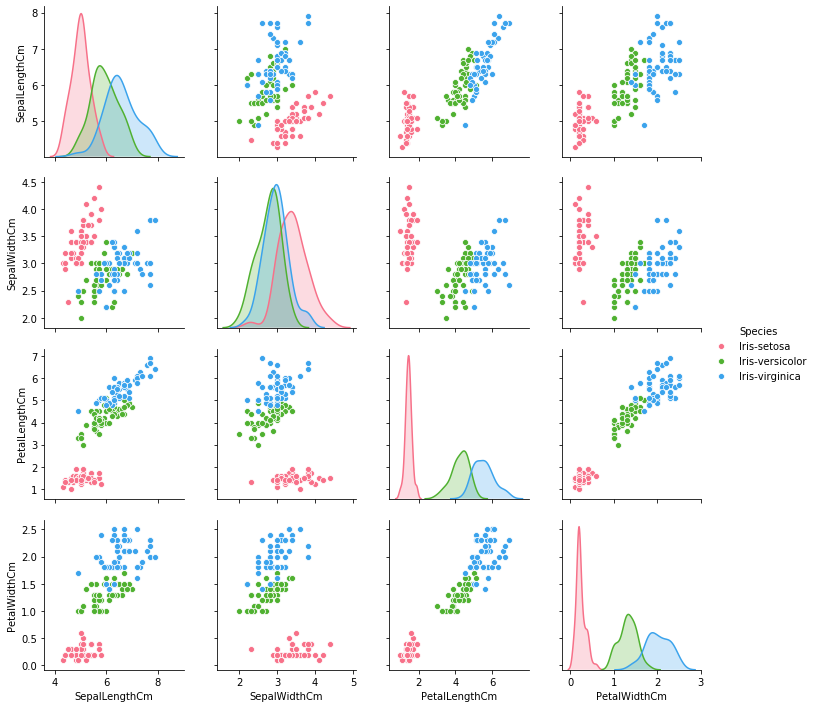

In [26]:
# View data with known labels as a comparison to future classifications done by k-means and max-cut
sns.pairplot(data=df,hue="Species",palette="husl")
plt.show()

In [27]:
# Remove Iris labels (otherwise it's not unsurpervised learning!)
data = df.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [28]:
# Use k-means clustering as classical unsupervised learning method (to compare to quantum method later)

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(data)//10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    dis.append(kmeans.inertia_)

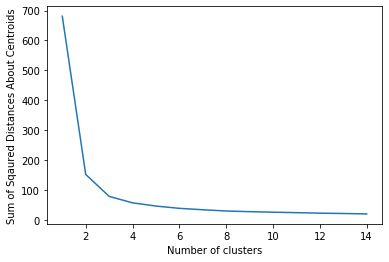

In [29]:
# Visualize Optimal k
plt.plot(K,dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

# Looks like 3 (maybe 2?) is most elbowy and thus the optimal k

In [11]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data)

In [12]:
df['label'] = kmeans.labels_
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,label
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


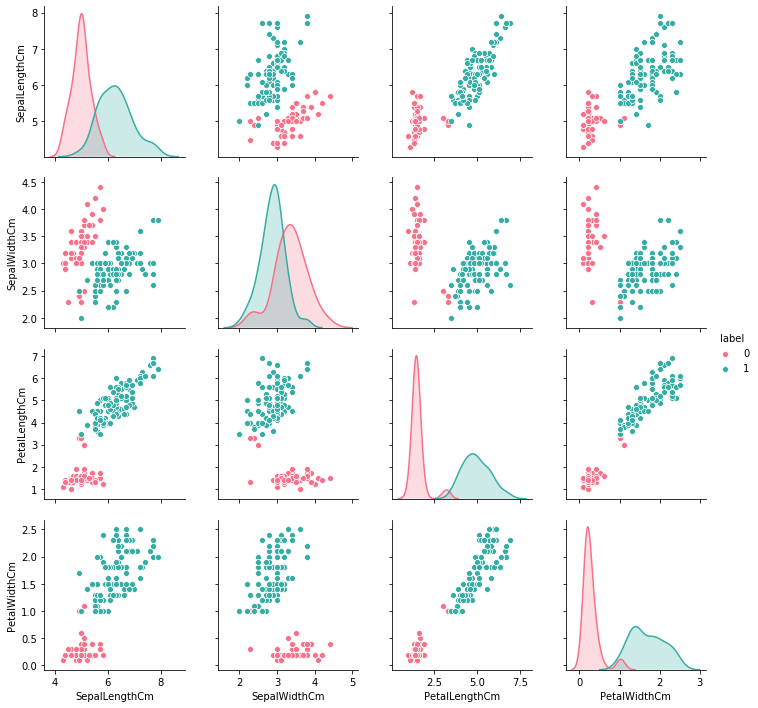

In [13]:
# Visualize data
sns.pairplot(data=df,hue='label',palette="husl",vars=df.columns[:-2])
plt.show()

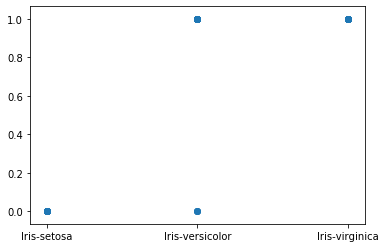

In [14]:
# Compare new labels to known labels
plt.scatter(df['Species'], df['label'])
plt.show()

In [15]:
# Count misclassifications
set_mis_label = (df[df['Species'] == 'Iris-setosa']['label'].sum()) / df[df['Species'] == 'Iris-setosa']['Species'].count()
veris_mis_label = (df[df['Species'] == 'Iris-versicolor']['label'].sum()) / df[df['Species'] == 'Iris-versicolor']['Species'].count()
virg_mis_label = (df[df['Species'] == 'Iris-virginica']['label'].sum()) / df[df['Species'] == 'Iris-virginica']['Species'].count()

print(set_mis_label,veris_mis_label,virg_mis_label)

0.0 0.94 1.0


Unsupervised learning means a lack of labels: we are looking for structure in the data, without having an *a priori* intuition what that structure might be. A great example is clustering, where the goal is to identify instances that clump together in some high-dimensional space. Unsupervised learning in general is a harder problem. Deep learning revolutionized supervised learning and it had made significant advances in unsupervised learning, but there remains plenty of room for improvement. In this notebook, we look at how we can map an unsupervised learning problem to graph optimization, which in turn we can solve on a quantum computer.

# Mapping clustering to discrete optimization

Assume that we have some points $\{x_i\}_{i=1}^N$ lying in some high-dimensional space $\mathbb{R}^d$. How do we tell which ones are close to one another and which ones are distant? To get some intuition, let's generate a simple dataset with two distinct classes. The first five instances will belong to class 1, and the second five to class 2:

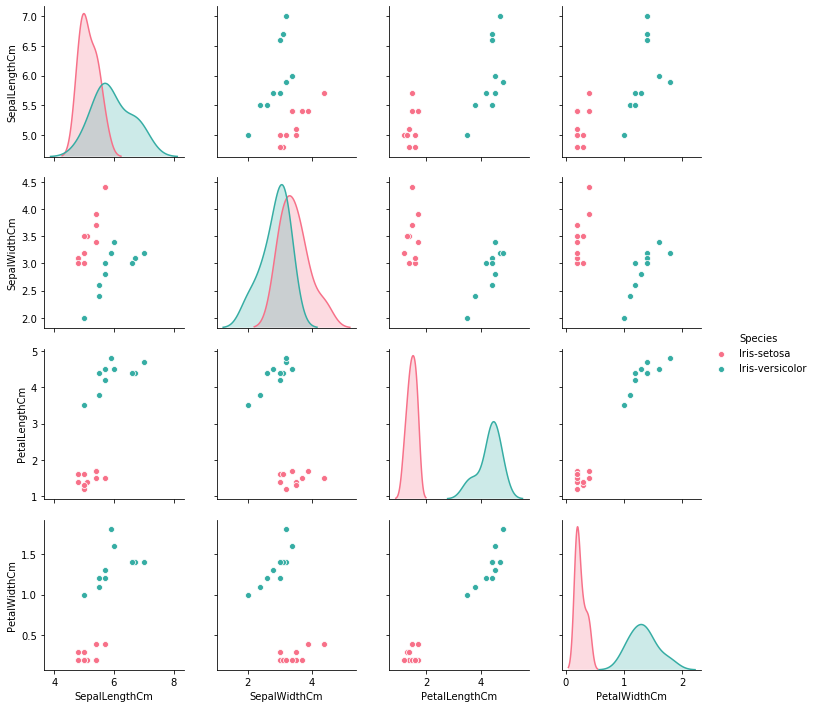

In [16]:
# Consider subset of data due to number of qubit constraints
df_sub = df.iloc[::5,:5].reset_index(drop=True)
# Constrain data to only 2 species
df_sub = df_sub.loc[(df_sub['Species'] == 'Iris-setosa') | (df_sub['Species'] == 'Iris-versicolor')]
sns.pairplot(data=df_sub,hue="Species",palette="husl")
plt.show()

In [17]:
# Remove Iris labels
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,5.4,3.9,1.7,0.4
2,5.4,3.7,1.5,0.2
3,5.7,4.4,1.5,0.4
4,5.4,3.4,1.7,0.2


In [18]:
# Get number of data entries
n_instances = len(data)

# Convert dataframe into array in 4D space
data_array = data.values

The high-dimensional space is endowed with some measure of distance, the Euclidean distance being the simplest case. We can calculate all pairwise distances between the data points:

In [19]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
w.shape

(20, 20)

In [16]:
# Estimate maxcut classically. From qiskit max-cut notebook: https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb
# Calculate the max cut
best = 0
for b in range(2**n_instances):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n_instances)))]
    cost = 0
    for i in range(n_instances):
        for j in range(n_instances):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best < cost:
        best = cost
        xbest_brute = x 
    
print('Optimal Solution: case = ' + str(xbest_brute) + ', cost = ' + str(best))

KeyboardInterrupt: 

This matrix is sometimes called the Gram or the kernel matrix. The Gram matrix contains a fair bit of information about the topology of the points in the high-dimensional space, but it is not easy to see. We can think of the Gram matrix as the weighted adjacency matrix of a graph: two nodes represent two data instances. Their distance as contained in the Gram matrix is the weight on the edge that connects them. If the distance is zero, they are not connected by an edge. In general, this is a dense graph with many edges -- sparsity can be improved by a distance function that gets exponentially smaller.

What can we do with this graph to find the clusters? We could look for the max-cut, that is, the collection of edges that would split the graph in exactly two if removed, while maximizing the total weight of these edges [[1](#1)]. This is a well-known NP-hard problem, but it also very naturally maps to an Ising model.

The spin variables $\sigma_i \in \{-1, +1\}$ take on value $\sigma_i = +1$ if a data instance is in cluster 1 (nodes $V_1$ in the graph), and $\sigma_i = -1$ if the data instance is in cluster 2 (nodes $V_2$ in the graph). The cost of a cut is

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

Let us assume a fully connected graph. Then, accounting for the symmetry of the adjacency matrix, we can expand this as
$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

By taking the negative of this, we can directly solve the problem by a quantum optimizer.

# Solving the max-cut problem by QAOA

Most quantum computing frameworks have convenience functions defined for common graph optimization algorithms, and max-cut is a staple. This reduces our task to importing the relevant functions:

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

Here the choice of the classical optimizer `COBYLA` was arbitrary. Let us run this and analyze the solution. This can take a while on a classical simulator.

Code is from [qiskit tutorial](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/optimization/max_cut.ipynb)

In [20]:
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut

In [21]:
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

In [22]:
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'algorithm': algorithm_cfg,
}
result = run_algorithm(params,algo_input)
x = max_cut.sample_most_likely(result['eigvecs'][0])

print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


energy: -124.4266225175067
max-cut objective: -331.4020653233265
solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
solution objective: 331.4020653233264


In [23]:
labels = pd.DataFrame(max_cut.get_graph_solution(x),columns=['label'])
print('unique labels:',labels['label'].unique())

df_sub['label'] = labels
df_sub.head()

unique labels: [1. 0.]


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,label
0,5.1,3.5,1.4,0.2,Iris-setosa,1.0
1,5.4,3.9,1.7,0.4,Iris-setosa,1.0
2,5.4,3.7,1.5,0.2,Iris-setosa,1.0
3,5.7,4.4,1.5,0.4,Iris-setosa,1.0
4,5.4,3.4,1.7,0.2,Iris-setosa,1.0


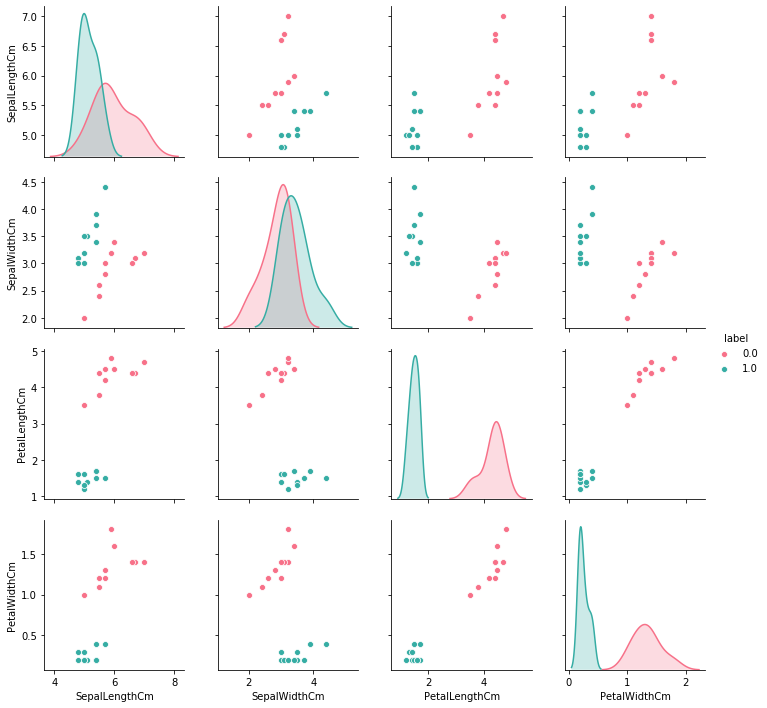

In [24]:
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

Looking at the solution, the cut matches the clustering structure.

# Solving the max-cut problem by annealing

Naturally, the same problem can be solved on an annealer. Our only task is to translate the couplings and the on-site fields to match the programming interface:

In [24]:
import dimod

J, h = {}, {}
for i in range(n_instances):
    h[i] = 0
    for j in range(i+1, n_instances):
        J[(i, j)] = w[i, j]

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
for solution in response.data():
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -248.85324503501346 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1}
Energy: -248.85324503501346 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1}
Energy: -248.85324503501346 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1}
Energy: -248.85324503501346 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1}
Energy: -248.85324503501346 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1}
Energy: -248.85324503501346 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: 

In [25]:
labels = pd.DataFrame(data=solution.sample,index=[0]).T
labels = labels.rename(columns={0:'label'})
print('unique labels:',labels['label'].unique())

df_sub['label'] = labels
df_sub.head()

unique labels: [-1  1]


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,label
0,5.1,3.5,1.4,0.2,Iris-setosa,-1
1,5.4,3.9,1.7,0.4,Iris-setosa,-1
2,5.4,3.7,1.5,0.2,Iris-setosa,-1
3,5.7,4.4,1.5,0.4,Iris-setosa,-1
4,5.4,3.4,1.7,0.2,Iris-setosa,-1


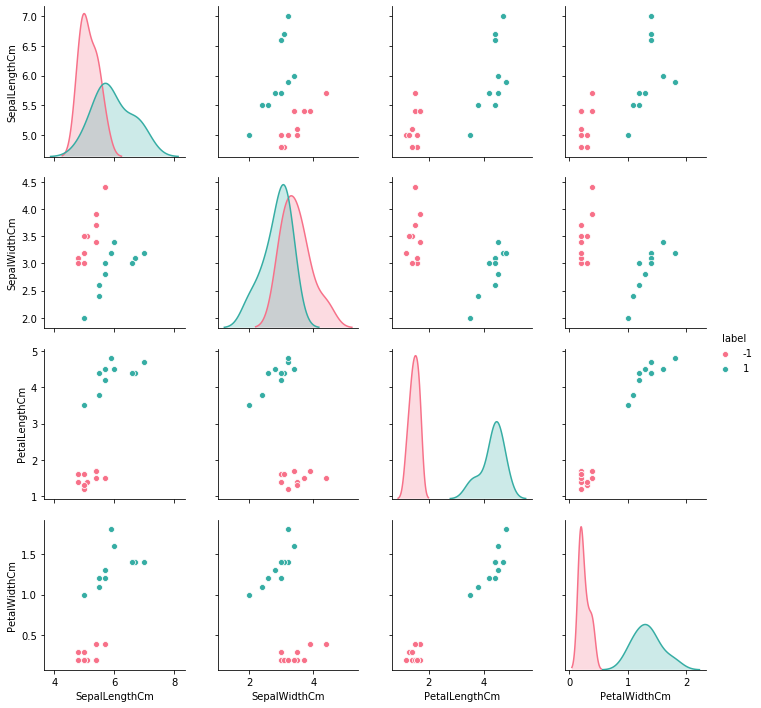

In [26]:
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

If you look at the first sample, you will see that the first five data instances belong to the same graph partition, matching the actual cluster.

# References

[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>